In [4]:
# import all necessary packages for CBOW
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import random
import os
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import collections
import itertools
import re
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
from nltk.stem import WordNetLemmatizer
from scipy.stats import pearsonr, spearmanr
from sklearn.model_selection import train_test_split
from gensim import matutils
from numpy import dot

ImportError: cannot import name 'triu' from 'scipy.linalg' (/opt/conda/lib/python3.9/site-packages/scipy/linalg/__init__.py)

In [5]:
!pwd

/projects/rtelidevara/pk/Part_A/skipgram


In [6]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print device name: get_device_name()
print(torch.cuda.get_device_name(0))

Tesla V100-SXM2-32GB


In [7]:
# Load data from file and store list of sentences where sentences are list of words
class MakeSentences():
    def __init__(self, file_name):
        self.file_name = file_name
        self.sentences = self.read_file()

    def read_file(self):
        sentences = []
        with open(self.file_name, 'r') as f:
            i=0
            for line in f:
                sentences += ([x for x in line.strip().split('.') if x!=''])
                i+=1
                if i==10000:
                    break
        return sentences

In [8]:
!pwd

/projects/rtelidevara/pk/Part_A/skipgram


In [9]:
sentences = MakeSentences('../sa_sentences.txt').sentences
print(len(sentences))
# for sentence in sentences:
#     print(type(sentence))

11284


### Preprocess

In [10]:
import re
from collections import Counter

class Preprocess():
    def __init__(self, sentences):
        self.sentences = sentences

    def tokenize(self):
        # Split sentences into words using regex to handle various punctuation
        self.sentences = [re.findall(r'\b\w+\b', sentence.lower()) for sentence in self.sentences]

    def lowercase(self):
        self.sentences = [[word.lower() for word in sentence] for sentence in self.sentences]

    def remove_stop_words(self):
        # Common English stop words; expand as necessary
        stop_words = set(["the", "is", "at", "which", "on", "and", "a", "an"])
        self.sentences = [[word for word in sentence if word not in stop_words] for sentence in self.sentences]

    def stemmer(self):
        # Simple stemming using suffix stripping, can be improved
        def simple_stem(word):
            suffixes = ["ing", "ly", "ed", "ious", "ies", "ive", "es", "s", "ment"]
            for suffix in sorted(suffixes, key=len, reverse=True):
                if word.endswith(suffix):
                    return word[:-len(suffix)]
            return word
        self.sentences = [[simple_stem(word) for word in sentence] for sentence in self.sentences]

    def remove_punctuation(self):
        self.sentences = [[word for word in sentence if word.isalpha()] for sentence in self.sentences]

    def remove_numbers(self):
        self.sentences = [[word for word in sentence if not word.isdigit()] for sentence in self.sentences]

    def remove_single_letter(self):
        self.sentences = [[word for word in sentence if len(word) > 1] for sentence in self.sentences]

    def remove_extra_spaces(self):
        self.sentences = [[word for word in sentence if word.strip()] for sentence in self.sentences]

    def remove_less_than_3(self):
        self.sentences = [[word for word in sentence if len(word) > 2] for sentence in self.sentences]


In [11]:
# preprocess
preprocess = Preprocess(sentences)
preprocess.tokenize()
# print(preprocess.sentences)
preprocess.lowercase()
preprocess.remove_stop_words()
# preprocess.stemmer()
preprocess.remove_punctuation()
preprocess.remove_numbers()
preprocess.remove_single_letter()
preprocess.remove_extra_spaces()
preprocess.remove_less_than_3()

print("Preprocessing done")
# print(preprocess.sentences)
sentences = preprocess.sentences
print(len(sentences))
# print(sentences)

Preprocessing done
11284


### Create word index mappings

In [12]:
# Flatten list of sentences into list of words
word_list = list(itertools.chain.from_iterable(sentences))
# print(word_list)

# Create a vocabulary of words
word_freq = Counter(word_list)

# Remove words that occur less than 5 times
vocab = set(word if word_freq[word] > 0 else '<unk>' for word in word_list)
# print(vocab)

# Add padding and unknown token to vocab
vocab.add('<pad>')
vocab.add('<unk>')
# Add start and end token to vocab
vocab.add('<start>')
vocab.add('<end>')

# Print length of vocab
print("Size of vocab: ", len(vocab))

# Create word to index and index to word mapping
word_to_idx = {word:idx for idx, word in enumerate(vocab)}
idx_to_word = {idx:word for idx, word in enumerate(vocab)}

# Print most common words
print("Most common words: ", word_freq.most_common(10))

Size of vocab:  33805
Most common words:  [('for', 2225), ('with', 1959), ('was', 1786), ('that', 1728), ('has', 1351), ('from', 1288), ('his', 1073), ('after', 763), ('who', 752), ('been', 737)]


In [13]:
# Check
print(word_to_idx['intelligent'])

22085


### Create dataset (X,y)

In [14]:
import random
# define constants
window_size = 2
sliding_window = 2 * window_size + 1
num_neg_samples = 1
# print(sentences)

# sentences = [sentences[0]]
# print(sentences)
def select_negative_samples(target_word, num_window_size, unigram_table):
    negative_samples = []
    while len(negative_samples) < 2*num_window_size:
        sampled_word = random.choice(unigram_table)  # unigram_table is precomputed based on the distribution
        if sampled_word != target_word:
            negative_samples.append(sampled_word)
    return negative_samples

def create_unigram_table(vocab, table_size=len(vocab)):
    unigram_table = []
    total_count_power = sum([count**0.75 for count in vocab.values()])
    for word, count in vocab.items():
        p_wi = (count**0.75) / total_count_power
        # Fill the table with the index of the word
        unigram_table.extend([word] * int(p_wi * table_size))
    return unigram_table

unigram_table = create_unigram_table(word_freq)
# print(unigram_table)

def get_samples(sentences, word_to_idx, idx_to_word, window_size, sliding_window, num_neg_sample , vocab , unigram_table):
    X = []
    y = []
    for sentence in sentences:
        # add start and end token to sentence
        sentence = ['<start>'] + sentence + ['<end>']
        for i in range(len(sentence)):
            context_word = sentence[i]
            # print("target word: ", target_word)
            target_words = []
            temp1 = max(0,i - window_size)
            temp2 = min(len(sentence)-1,i + window_size + 1)
            # print("temp1: ", temp1)
            # print("temp2: ", temp2)
            for j in range(max(0,i - window_size),min(len(sentence)-1,i + window_size)+1):
                if j != i:
                    # print(sentence[j])
                    target_words.append(sentence[j])
                # print("context words: ", context_words)


            # pad context words if length is less than sliding window
            if len(target_words) < sliding_window:
                target_words += ['<pad>'] * (sliding_window - len(target_words)-1)

            target_words.append(context_word)
            # print("length of target words: ", len(target_words))

            # get positive samples
            positive_samples = [word_to_idx[word] if word in vocab else word_to_idx['<unk>'] for word in target_words]
            # print("lenght of positive samples: ", len(positive_samples))

            X.append(positive_samples)
            y.append(1)


            # get negative samples
            for i in range(num_neg_samples):
                negative_samples = select_negative_samples(context_word, window_size, unigram_table)
                negative_samples = [word_to_idx[word] if word in vocab else word_to_idx['<unk>'] for word in negative_samples]
                negative_samples += [word_to_idx['<pad>']] * (sliding_window - len(negative_samples)-1)
                negative_samples.append(word_to_idx[context_word])
                X.append(negative_samples)
                y.append(0)
                # print("length of negative samples: ", len(negative_samples))


    return X, y

In [15]:
print("Creating samples")
X, y = get_samples(sentences, word_to_idx, idx_to_word, window_size, sliding_window, num_neg_samples, vocab, unigram_table)
print(X[2])
print(y[2])
print("Samples created")

Creating samples
[5127, 9196, 9196, 9196, 20584]
1
Samples created


In [16]:
# shuffle data
data = list(zip(X,y))
random.shuffle(data)
X,y = zip(*data)

# Turn into numpy arrays
X = np.array(X)
y = np.array(y)

In [17]:
# Save X and y
np.save('./datasets/skip_sa_X_25k.npy', X)
np.save('./datasets/skip_sa_y_25k.npy', y)

In [18]:
# # Load X and y
X = np.load('./datasets/skip_sa_X_25k.npy')
y = np.load('./datasets/skip_sa_y_25k.npy')

### Build Model

In [19]:
# write the forward pass for SkipGram
class SkipGram(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(SkipGram, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.embeddings = nn.Embedding(self.vocab_size, self.embedding_dim)
        # self.embeddings.weight.data.uniform_(-1, 1)

    def forward(self, x):
        # extract context and target from x
        context = x[:, :-1]
        input = x[:, -1]

        context_embedding = self.embeddings(context)
        input_embedding = self.embeddings(input)

        # Dot product between each context embedding and input embedding to get batch_size*context_size*embedding_dim

        dot_products = torch.bmm(context_embedding, input_embedding.unsqueeze(2))  # [batch_size, context_length, 1]
        sum_dot_products = torch.sum(dot_products, dim=1)  # [batch_size, 1]

        # Squeeze the last dimension to get the final scores
        scores = sum_dot_products.squeeze(1)  # [batch_size]

        return F.sigmoid(scores)

    def get_embeddings(self):
        out = self.embeddings.weight.data
        return out.cpu().numpy()

    def get_word_embedding(self, word):
        # If word is not in vocab, return unk
        if word not in word_to_idx:
            word = '<unk>'
        word_tensor = torch.LongTensor([word_to_idx[word]])
        word_tensor = word_tensor.to(next(self.parameters()).device)
        out = self.embeddings(word_tensor).data
        return out.cpu().numpy()

In [20]:
# Define parameters
vocab_size = len(vocab)
embedding_dim = 250
learning_rate = 0.001
epochs = 10
batch_size = 128

# Create model, loss function and optimizer
model = SkipGram(vocab_size, embedding_dim)
model.to(device)
# Cross entropy loss
criterion = nn.BCELoss()

# Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Define dataloader
dataset = torch.utils.data.TensorDataset(torch.from_numpy(X).long(), torch.from_numpy(y).float())
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [21]:
# Check dataset
for i, (inputs, targets) in enumerate(dataloader):
    print(inputs)
    print(targets)
    break

tensor([[ 4287, 12072,  5067,  3425,  9922],
        [18709,  1271, 10779,  9509, 16931],
        [18573,  3319, 32524, 24952, 25497],
        [ 1593,   844,  3744,  4912, 27127],
        [17800, 33221, 21392,  6392, 28540],
        [13067,   977, 10285,   493,  2429],
        [ 5127,  7649,  5944,  9196, 24003],
        [  673, 22510,  9196,  9196,  5127],
        [ 2962,  2429, 24201, 20584, 18433],
        [21779, 12673,  9275, 12637, 27421],
        [31003,   536,   665, 19935, 21976],
        [28694,  9992, 31971,  9149,  8838],
        [18759, 26426, 17459, 31626, 13241],
        [12926, 14725,  2312,  4736, 24297],
        [18639,  2891, 23510, 27558, 14183],
        [ 4583, 15382, 31774, 11244, 10368],
        [21387,  7951, 18352, 29190, 32920],
        [32843, 29711,  6433, 32843,  2090],
        [ 8779, 20696, 20582, 25420,  4912],
        [29245,  7850, 29954, 20517, 29524],
        [ 8452, 20754, 14769, 16548,  4662],
        [30104,   767, 27105, 19276, 19935],
        [ 

In [22]:
# Train SkipGram model
def train(model, criterion, optimizer, dataloader, epochs):
    train_losses = []
    for epoch in range(epochs):
        train_loss = 0
        train_preds = []
        labels = []
        for i, (inputs, targets) in enumerate(dataloader):
            inputs = inputs.to(device)
            targets = targets.to(device)

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            # get predictions
            preds = [1 if x > 0.5 else 0 for x in outputs]
            train_preds.extend(preds)
            targets = targets.detach().cpu().numpy()
            labels.extend(targets)
        
        train_loss /= len(dataloader)
        train_losses.append(train_loss)
        print("Epoch: ", epoch+1, "Loss: ", train_loss)
    return train_losses

In [23]:
# Train model
train_losses = train(model, criterion, optimizer, dataloader, epochs)

Epoch:  1 Loss:  20.29098311936783
Epoch:  2 Loss:  16.830807559488598
Epoch:  3 Loss:  15.073676278280875
Epoch:  4 Loss:  14.04376164370104
Epoch:  5 Loss:  13.343995393005804
Epoch:  6 Loss:  12.850327803488929
Epoch:  7 Loss:  12.480959152580514
Epoch:  8 Loss:  12.15917039608843
Epoch:  9 Loss:  11.906831601143526
Epoch:  10 Loss:  11.681309587394395


In [24]:
# Function to plot train accuracy
def plot_train_losses(train_losses):
    plt.plot(train_losses)
    plt.xlabel('Epochs')
    plt.ylabel('Train Loss')
    plt.title('Train Loss vs Epochs')
    plt.savefig('./plots/skip_sa_train_losses.png')
    plt.show()

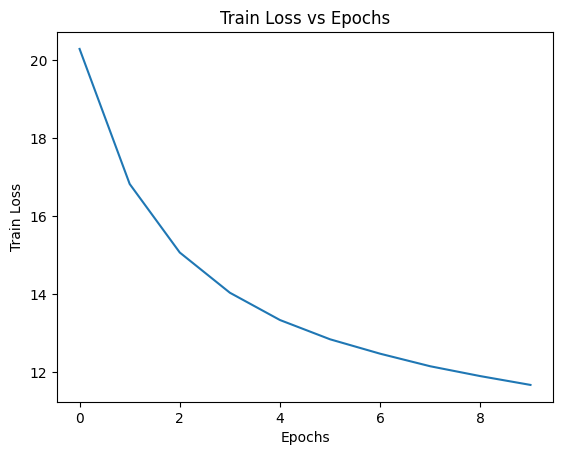

In [25]:
# Call function to plot train accuracy
plot_train_losses(train_losses)

In [26]:
# Save model
torch.save(model, './partA_pth/skipgram_sa_25k_250_001.pth')

In [27]:
# Load model
model = SkipGram(vocab_size, embedding_dim)
model = torch.load('./partA_pth/skipgram_sa_25k_250_001.pth')
model.to(device)

SkipGram(
  (embeddings): Embedding(33805, 250)
)

In [28]:
# Load test data

# Load into dataframe
df = pd.read_csv('../SimLex-999/SimLex-999.txt', sep='\t')
print(df.head())

   word1        word2 POS  SimLex999  conc(w1)  conc(w2)  concQ  Assoc(USF)  \
0    old          new   A       1.58      2.72      2.81      2        7.25   
1  smart  intelligent   A       9.20      1.75      2.46      1        7.11   
2   hard    difficult   A       8.77      3.76      2.21      2        5.94   
3  happy     cheerful   A       9.55      2.56      2.34      1        5.85   
4   hard         easy   A       0.95      3.76      2.07      2        5.82   

   SimAssoc333  SD(SimLex)  
0            1        0.41  
1            1        0.67  
2            1        1.19  
3            1        2.18  
4            1        0.93  


In [29]:
# Print 2nd row word1
print(df['word1'][1])

smart


In [30]:
# Get word embeddings
sample_embedding = model.get_word_embedding(df['word1'][1])
print(sample_embedding.shape)
sample_embedding = sample_embedding.squeeze()
print(sample_embedding.shape)
print(sample_embedding)

(1, 250)
(250,)
[ 1.2981591  -0.7140056  -0.7623678   0.0328537  -1.493342    0.49984252
 -0.5490612   1.5202856   0.9398308  -0.7862399   0.02128123 -0.5661481
 -1.3100903   0.7852158  -0.9473987   1.9733192   0.6274865   0.65383935
  0.16591056  0.12509073 -0.39099595  0.20386589 -0.20119318 -0.032251
  1.138302   -0.61773074 -0.35346246 -1.5451616  -0.21245751  1.3896084
  0.6694425   0.82525194  0.5937259  -1.3512334  -0.03174135 -0.59977067
 -0.8568651  -1.2783841  -0.42700535  0.27779573  0.45159888 -0.53618675
 -0.315613    0.58182895 -0.87995017 -0.6136408   0.8035155   0.00708674
  1.1724242  -1.195392   -0.10448891 -0.09020063  0.00513496  0.09511915
 -0.47837543 -0.10028946  0.49363235 -2.049493   -0.4678749  -1.0476667
 -0.39492512 -1.2502239  -0.54735893 -0.244681   -0.70778364  0.7640808
 -0.43341014  1.0486573  -0.11795577  1.5118635  -0.74309224 -1.6483552
 -1.2236825  -1.2644749  -0.9735757   0.22730672  2.3880107   0.3406175
  0.6077989   1.3500601  -2.0064626   1.662

In [31]:
import numpy as np

# Check similarity between two words
word1 = df['word1'][1]
word2 = df['word1'][1]

# Use gensim or any other model to get word embeddings
w1 = model.get_word_embedding(word1).squeeze()
w2 = model.get_word_embedding(word2).squeeze()

print(type(w1))

# Calculate cosine similarity using numpy
def unitvec(vec):
    return vec / np.linalg.norm(vec)

sim = np.dot(unitvec(w1), unitvec(w2))
print(sim)

<class 'numpy.ndarray'>
1.0


In [32]:
# Function to check if word is in vocab
def check_vocab(word):
    if word in vocab:
        return True
    else:
        return False

In [33]:
# Function to get cosine similarity
import numpy as np

def cos_similarity(word1_embedding, word2_embedding):
    def unitvec(vec):
        return vec / np.linalg.norm(vec)

    ans = np.dot(unitvec(word1_embedding), unitvec(word2_embedding))
    return ans


# Function to get Pearson correlation
def pearson_correlation(word1_embedding, word2_embedding):
    emb1 = np.array(word1_embedding)
    emb2 = np.array(word2_embedding)

    correlation, _ = pearsonr(emb1, emb2)
    return correlation

In [34]:
def test_sim(df, model, lemmatizer, stemmer):
    cosine_similarity_scores = []
    pearson_correlation_scores = []
    simlex_scores = []
    not_in_vocab = 0
  
    for _, row in df.iterrows():
        word1 = row['word1']
        word2 = row['word2']
        form = row['POS']
        form = form.lower()
       
        # Check if word is in vocab
        if not check_vocab(word1) or not check_vocab(word2):
            not_in_vocab += 1

        # Get embeddings
        word1_embedding = model.get_word_embedding(word1).squeeze()
        word2_embedding = model.get_word_embedding(word2).squeeze()

        # Get cosine similarity
        cosine_similarity_scores.append(cos_similarity(word1_embedding, word2_embedding))
        
        # Get pearson correlation
        pearson_correlation_scores.append(pearson_correlation(word1_embedding, word2_embedding))

        # Get simlex score
        simlex_scores.append(row['SimLex999'])
        
    return cosine_similarity_scores, pearson_correlation_scores, simlex_scores, not_in_vocab

In [35]:
# Get cosine similarity and pearson correlation scores
lemmatizer = WordNetLemmatizer()
stemmer = nltk.stem.PorterStemmer()
cosine_similarity_scores, pearson_correlation_scores, simlex_scores, not_in_vocab = test_sim(df, model, lemmatizer, stemmer)

In [36]:
# Check cosine similarity and pearson correlation scores
print(type(cosine_similarity_scores))
print(type(pearson_correlation_scores))
print(type(simlex_scores))

<class 'list'>
<class 'list'>
<class 'list'>


In [37]:
# Funtcion to get spearman correlation using cosine similarity scores
def spearman_correlation(cosine_similarity_scores, simlex_scores):
    # Scale cosine similarity scores to 0-10
    cosine_similarity_scores = np.array(cosine_similarity_scores)
    cosine_similarity_scores = (1+cosine_similarity_scores)*5
    simlex_scores = np.array(simlex_scores)

    correlation, _ = spearmanr(cosine_similarity_scores, simlex_scores)
    return correlation

In [38]:
# Print the initial spearman correlation
spearman_value_sim = spearman_correlation(cosine_similarity_scores, simlex_scores)

print("Initial Spearman correlation Sim: ", spearman_value_sim)

Initial Spearman correlation Sim:  -0.005468586187342618


In [39]:
# Print the number of data points not in vocab
print("Number of data points not in vocab: ", not_in_vocab)

Number of data points not in vocab:  106


In [40]:
# Make a dataframe of cosine similarity scores and pearson correlation scores along with Simlex-999 scores and Assoc(USF)
simlex_scores = df['SimLex999']
assoc_scores = df['Assoc(USF)']
cosine_similarity_scores = np.array(cosine_similarity_scores)
pearson_correlation_scores = np.array(pearson_correlation_scores)
simlex_scores = np.array(simlex_scores)
assoc_scores = np.array(assoc_scores)
# print(cosine_similarity_scores.shape)
# print(pearson_correlation_scores.shape)

# Make a dataframe along with word1, word2, POS, SimLex-999 scores, Assoc(USF), cosine similarity scores and pearson correlation scores
datat = {'word1': df['word1'], 'word2': df['word2'], 'POS': df['POS'], 'SimLex999': simlex_scores, 'Assoc(USF)': assoc_scores, 'Cosine Similarity': cosine_similarity_scores, 'Pearson Correlation': pearson_correlation_scores}
ndf = pd.DataFrame(data=datat)
print(ndf.head())

   word1        word2 POS  SimLex999  Assoc(USF)  Cosine Similarity  \
0    old          new   A       1.58        7.25          -0.023388   
1  smart  intelligent   A       9.20        7.11           0.057215   
2   hard    difficult   A       8.77        5.94          -0.042206   
3  happy     cheerful   A       9.55        5.85          -0.002335   
4   hard         easy   A       0.95        5.82          -0.024750   

   Pearson Correlation  
0            -0.021782  
1             0.058058  
2            -0.039502  
3            -0.003792  
4            -0.023280  


In [41]:
# Print df
print(ndf)

      word1        word2 POS  SimLex999  Assoc(USF)  Cosine Similarity  \
0       old          new   A       1.58        7.25          -0.023388   
1     smart  intelligent   A       9.20        7.11           0.057215   
2      hard    difficult   A       8.77        5.94          -0.042206   
3     happy     cheerful   A       9.55        5.85          -0.002335   
4      hard         easy   A       0.95        5.82          -0.024750   
..      ...          ...  ..        ...         ...                ...   
994    join      acquire   V       2.85        0.00           0.064023   
995    send       attend   V       1.67        0.00          -0.045031   
996  gather       attend   V       4.80        0.00           0.002795   
997  absorb     withdraw   V       2.97        0.00           0.096633   
998  attend       arrive   V       6.08        0.00           0.101605   

     Pearson Correlation  
0              -0.021782  
1               0.058058  
2              -0.039502  
3  

Build Model

In [42]:
# Create Dataset
def create_dataset(df, model):
    # Create a list of tuples
    emb1 = []
    emb2 = []
    simlex_scores = []
    assoc_scores = []
    for _, row in df.iterrows():
            word1 = row['word1']
            word2 = row['word2']
            emb1.append(torch.tensor(model.get_word_embedding(word1).squeeze()))
            emb2.append(torch.tensor(model.get_word_embedding(word2).squeeze()))
            simlex_scores.append(row['SimLex999'])
            assoc_scores.append(row['Assoc(USF)'])

    # print(emb1[0].shape)
    emb1_stack = torch.stack(emb1)
    emb2_stack = torch.stack(emb2)

    return emb1_stack, emb2_stack, torch.tensor(simlex_scores, dtype=torch.float), torch.tensor(assoc_scores, dtype=torch.float)

In [43]:
# Call create_dataset
train_df, test_df = train_test_split(ndf, test_size=0.1, random_state=42)
train_emb1, train_emb2, train_simlex_scores, train_assoc_scores = create_dataset(train_df, model)
test_emb1, test_emb2, test_simlex_scores, test_assoc_scores = create_dataset(test_df, model)

In [44]:
# check train_emb1
print(train_emb1.shape)
print(train_simlex_scores.shape)

torch.Size([899, 250])
torch.Size([899])


In [45]:
# Creare TensorDataset
train_dataset = torch.utils.data.TensorDataset(train_emb1, train_emb2, train_simlex_scores, train_assoc_scores)
test_dataset = torch.utils.data.TensorDataset(test_emb1, test_emb2, test_simlex_scores, test_assoc_scores)

In [46]:
# Create DataLoader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

In [47]:
# Class that takes CBOW embeddings, and outputs similarity scores: loss is MSE between predicted similarity scores and actual similarity scores(Simlex-999)
# We're basically optimizing these weights over here used to produce this score out of 10, minimizing the distance between this score and the simlex score.
class RegressionModel(nn.Module):
    def __init__(self, embedding_dim):
        super(RegressionModel, self).__init__()
        self.linear1 = nn.Linear(2*embedding_dim, 50)
        self.linear2 = nn.Linear(50, 1)
        self.dropout = nn.Dropout(0.5)

    def forward(self, emb1, emb2):
        # emb1 = emb1.squeeze()
        # emb2 = emb2.squeeze()
        emb = torch.cat((emb1, emb2), dim=1)

        out = self.linear1(emb)
        out = F.relu(out)
        out = self.dropout(out)
        out = self.linear2(out)

        # Project the output between 0 and 10
        out = torch.sigmoid(out)
        out = out*10
        return out

In [48]:
# Model Parameters
embedding_dim = 250
learning_rate = 0.001
num_epochs = 20
batch_size = 32

# Initialize model
lmodel = RegressionModel(embedding_dim).to(device)
# Define loss function
criterion = nn.MSELoss()
# Define optimizer
optimizer = torch.optim.Adam(lmodel.parameters(), lr=learning_rate, weight_decay=0.01) # weight_decay is L2 regular

In [49]:
# Function to train model
def train(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    train_loss = 0.0
    for epoch in range(num_epochs):
        for emb1, emb2, simlex_scores, assoc_scores in train_loader:
            emb1 = emb1.to(device)
            emb2 = emb2.to(device)
            simlex_scores = simlex_scores.to(device)
            assoc_scores = assoc_scores.to(device)
            # Forward pass
            outputs = model(emb1, emb2)

            simlex_scores = simlex_scores.unsqueeze(1)
            # print(outputs[0])
            loss = criterion(outputs, simlex_scores)
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        print("Epoch: {}, Train_Loss: {}".format(epoch+1, train_loss))

In [50]:
# Train model
train(lmodel, train_loader, criterion, optimizer, num_epochs)

Epoch: 1, Train_Loss: 7.977085356054635
Epoch: 2, Train_Loss: 6.13643092958879
Epoch: 3, Train_Loss: 5.105762808846588
Epoch: 4, Train_Loss: 4.473104011372833
Epoch: 5, Train_Loss: 3.810090205154067
Epoch: 6, Train_Loss: 3.4329720824984724
Epoch: 7, Train_Loss: 3.1035643654651617
Epoch: 8, Train_Loss: 2.7543522761388317
Epoch: 9, Train_Loss: 2.4455570826795037
Epoch: 10, Train_Loss: 2.492960682031294
Epoch: 11, Train_Loss: 2.264081699769962
Epoch: 12, Train_Loss: 2.242992803390042
Epoch: 13, Train_Loss: 1.983674614077848
Epoch: 14, Train_Loss: 1.9656907514746862
Epoch: 15, Train_Loss: 1.7779041072966582
Epoch: 16, Train_Loss: 1.6108550989122292
Epoch: 17, Train_Loss: 1.4859312052133817
Epoch: 18, Train_Loss: 1.58288407077256
Epoch: 19, Train_Loss: 1.6395379221815705
Epoch: 20, Train_Loss: 1.4446653885278855


In [51]:
# Function to test model, Calculate test loss and Spearman correlation
def test(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    true_simlex_scores = []
    pred_simlex_scores = []
    for emb1, emb2, simlex_scores, assoc_scores in test_loader:
        emb1 = emb1.to(device)
        emb2 = emb2.to(device)
        simlex_scores = simlex_scores.to(device)
        assoc_scores = assoc_scores.to(device)
        # Forward pass
        outputs = model(emb1, emb2)
        simlex_scores = simlex_scores.unsqueeze(1)
        loss = criterion(outputs, simlex_scores)
        test_loss += loss.item()

        # Get true labels and predicted labels
        true_simlex_scores.extend(simlex_scores.cpu().detach().numpy().tolist())
        pred_simlex_scores.extend(outputs.cpu().detach().numpy().tolist())

    test_loss /= len(test_loader)
    print("Test_Loss: {}".format(test_loss))
    # Calculate Spearman correlation
    # print("True Simlex scores: ", true_simlex_scores)
    # print("Predicted Simlex scores: ", pred_simlex_scores)

    true_simlex_scores = np.array(true_simlex_scores)
    pred_simlex_scores = np.array(pred_simlex_scores)
    spear = spearmanr(true_simlex_scores, pred_simlex_scores)
    print("Spearman correlation: {}".format(spear[0]))

In [52]:
# Test model
test(lmodel, test_loader, criterion)

Test_Loss: 6.6201958656311035
Spearman correlation: 0.17343610775089385


In [100]:
%dropzone -p -src 'skipgram_sa.ipynb' -tgt 'skipgram_sa.ipynb'

HTML(value='')

/opt/conda/lib/python3.9/subprocess.py:941: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stdout = io.open(c2pread, 'rb', bufsize)
Host key verification failed.
Connection closed


DownloadWidget(children=(HBox(children=(Password(description='Dropzone Password:', style=DescriptionStyle(desc…